In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# hides warning messages but does not fix the underlying issue
import warnings
warnings.filterwarnings('ignore')

In [3]:
# models i will be comparing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for cross validation and tuning
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, cross_val_score

# set a consistent style for all plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("all libraries imported!!!!")

all libraries imported!!!!


## Data Loading

loading the preprocessed data

In [5]:
# this already has weather data, events, lag features, and all engineered features

df = pd.read_csv('unified_traffic_dataset.csv')

print(f'Dataset shape: {df.shape}')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'Total records: {len(df):,}')
print(f'Junctions: {df["junction"].unique()}')
print(f'\nFirst few rows:')
df.head()

Dataset shape: (48024, 30)
Date range: 2015-11-02 to 2017-06-30
Total records: 48,024
Junctions: [1 2 3 4]

First few rows:


,date,year,month,day_of_month,time,day_of_week,season,junction,vehicles,eventname,...,windspeedkmph_normalized,is_weekend,is_peak_hour,is_holiday,is_high_impact_event,vehicles_standardized,id,vehicles_lag_1h,vehicles_lag_2h,vehicles_lag_24h
0,2015-11-02,2015,11,2,0,0,Post-Monsoon,1,14,No Event,...,0.233333,0,0,0,0,-0.423682,20151102001,15.0,20.0,15.0
1,2015-11-02,2015,11,2,1,0,Post-Monsoon,1,12,No Event,...,0.233333,0,0,0,0,-0.520068,20151102011,14.0,15.0,13.0
2,2015-11-02,2015,11,2,2,0,Post-Monsoon,1,14,No Event,...,0.233333,0,0,0,0,-0.423682,20151102021,12.0,14.0,10.0
3,2015-11-02,2015,11,2,3,0,Post-Monsoon,1,12,No Event,...,0.233333,0,0,0,0,-0.520068,20151102031,14.0,12.0,7.0
4,2015-11-02,2015,11,2,4,0,Post-Monsoon,1,12,No Event,...,0.266667,0,0,0,0,-0.520068,20151102041,12.0,14.0,9.0


## Feature Selection

Not all columns should go into the model. I need to pick features that are genuinely useful for predicting traffic and avoid things that would cause data leakage.

In [6]:
# these are the features I'll use to predict traffic
# I'm keeping time features, weather, events, and lag features (past traffic)
# I'm NOT including normalized/standardized versions to keep things simple

feature_cols = [
    # time-based features - these capture daily and weekly patterns
    'time',           # hour of day (0-23)
    'day_of_week',    # monday=0, sunday=6
    'month',          # january=1, december=12
    'year',           # 2015, 2016, 2017
    'day_of_month',   # 1-31

    # location
    'junction',       # which junction (1-4)

    # binary indicators - yes/no type features
    'is_weekend',         # 1 if saturday/sunday
    'is_peak_hour',       # 1 if 7-10am or 5-8pm
    'is_holiday',         # 1 if national holiday
    'is_high_impact_event', # 1 if major event

    # weather conditions
    'temperature',    # degrees celsius
    'precipitation',  # rainfall in mm
    'humidity',       # humidity percentage
    'windspeedkmph',  # wind speed

    # lag features - these are the most powerful predictors!
    # they tell the model what traffic was like recently
    'vehicles_lag_1h',   # traffic 1 hour ago
    'vehicles_lag_2h',   # traffic 2 hours ago
    'vehicles_lag_24h',  # traffic at same time yesterday
]

# target variable - what I want to predict
target = 'vehicles'

print(f'Total features selected: {len(feature_cols)}')
print(f'Target variable: {target}')
print(f'\nFeature list:')
for i, col in enumerate(feature_cols, 1):
    print(f'  {i}. {col}')

Total features selected: 17
Target variable: vehicles

Feature list:
  1. time
  2. day_of_week
  3. month
  4. year
  5. day_of_month
  6. junction
  7. is_weekend
  8. is_peak_hour
  9. is_holiday
  10. is_high_impact_event
  11. temperature
  12. precipitation
  13. humidity
  14. windspeedkmph
  15. vehicles_lag_1h
  16. vehicles_lag_2h
  17. vehicles_lag_24h


In [8]:
df.head(5)

,date,year,month,day_of_month,time,day_of_week,season,junction,vehicles,eventname,...,windspeedkmph_normalized,is_weekend,is_peak_hour,is_holiday,is_high_impact_event,vehicles_standardized,id,vehicles_lag_1h,vehicles_lag_2h,vehicles_lag_24h
0,2015-11-02,2015,11,2,0,0,Post-Monsoon,1,14,No Event,...,0.233333,0,0,0,0,-0.423682,20151102001,15.0,20.0,15.0
1,2015-11-02,2015,11,2,0,0,Post-Monsoon,2,8,No Event,...,0.233333,0,0,0,0,-0.712841,20151102002,4.0,9.0,6.0
2,2015-11-02,2015,11,2,0,0,Post-Monsoon,3,5,No Event,...,0.233333,0,0,0,0,-0.857420,20151102003,5.0,6.0,9.0
3,2015-11-02,2015,11,2,1,0,Post-Monsoon,1,12,No Event,...,0.233333,0,0,0,0,-0.520068,20151102011,14.0,15.0,13.0
4,2015-11-02,2015,11,2,1,0,Post-Monsoon,2,6,No Event,...,0.233333,0,0,0,0,-0.809227,20151102012,8.0,4.0,6.0


## Time-Based Train/Test Split

This is really important  i can't use random splitting for time series data If I randomly split, some future data ends up in training, which is cheating. Instead I'll use the first 80% of time for training and the last 20% for testing.

Think of it like this: I train the model on 2015-2016 data, then test how well it predicts 2017 data. That's how it would work in real life.

In [7]:
# using January 2017 as the split point
# train = nov 2015 to dec 2016 (older data - model learns from this)
# test  = jan 2017 to jun 2017 (newer data - model gets tested on this)
split_date = '2017-01-01'

train_data = df[df['date'] < split_date].copy()
test_data  = df[df['date'] >= split_date].copy()

print('Dataset Split Summary:')
print(f'Training period: {train_data["date"].min()} to {train_data["date"].max()}')
print(f'Testing period:  {test_data["date"].min()} to {test_data["date"].max()}')
print(f'Training records: {len(train_data):,} ({len(train_data)/len(df)*100:.1f}%)')
print(f'Testing records:  {len(test_data):,} ({len(test_data)/len(df)*100:.1f}%)')

# prepare X (features) and y (target) for both sets
X_train = train_data[feature_cols]
y_train = train_data[target]
X_test  = test_data[feature_cols]
y_test  = test_data[target]

print(f'\nX_train shape: {X_train.shape}')
print(f'X_test shape:  {X_test.shape}')

Dataset Split Summary:
Training period: 2015-11-02 to 2016-12-31
Testing period:  2017-01-01 to 2017-06-30
Training records: 30,672 (63.9%)
Testing records:  17,352 (36.1%)

X_train shape: (30672, 17)
X_test shape:  (17352, 17)


## Model Development and Training

I'm going to train three different models and compare them:
1. **Linear Regression** - simplest model, good as a baseline to compare against
2. **Random Forest** - uses many decision trees together, handles non-linear patterns well
3. **Gradient Boosting** - builds trees one at a time, each fixing errors of the previous one

Random Forest and Gradient Boosting are tree-based models (as suggested in the task) and work really well for this kind of problem.

In [11]:
# Model 1: linear regression
# simple baseline - assumes traffic is a linear combination of all features
# good starting point to see what minimum performance looks like
print('training model 1: Linear Regression')
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
print('trained linear regression!')

# Model 2:random forest
# builds 100 decision trees and averages their predictions
# great at capturing complex patterns like peak hours and weather interactions
print('Training model 2: Random Forest...')
rf_model = RandomForestRegressor(n_estimators=100,   # number of trees
                                max_depth=15,       # how deep each tree can grow
                                min_samples_split=5, # minimum samples needed to split a node
                                random_state=42,    # for reproducibility
                                n_jobs=-1           # use all available CPU cores to speed things up   
                                )
rf_model.fit(X_train, y_train)
print('trained random forest!')

# Model 3: gradient boosting
# builds trees sequentially - each tree tries to fix what the previous ones got wrong
# often gives the best accuracy but takes longer to train
print('training model 3: Gradient Boosting...')
gb_model = GradientBoostingRegressor( n_estimators=100,   # number of boosting rounds
                                      max_depth=5,        # depth of each tree (smaller trees to avoid overfitting)
                                      learning_rate=0.1,  # how much each tree contributes (smaller = more careful)
                                      random_state=42)
gb_model.fit(X_train, y_train)
print('trained xgboost!')

print('all 3 models trained successfully!')

training model 1: Linear Regression
trained linear regression!
Training model 2: Random Forest...
trained random forest!
training model 3: Gradient Boosting...
trained xgboost!
all 3 models trained successfully!


## Model Evaluation

Now let's see how each model actually performs. I'll use three metrics:

- **MAE (Mean Absolute Error):** On average, how many vehicles off is the prediction? Lower is better.
- **RMSE (Root Mean Square Error):** Similar to MAE but punishes big errors more. Lower is better.
- **R² Score:** How much of the variance does the model explain? Closer to 1.0 is better.

In [15]:
# evaluate all three models and store results
models = {'Linear Regression': lr_model,
           'Random Forest': rf_model,
          'Gradient Boosting': gb_model}

results = {}


print('model evaluation results :')


for model_name, model in models.items():
    # make predictions on the test set
    y_pred = model.predict(X_test)

    # calculate all three metrics
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    # store for comparison later
    results[model_name] = {'MAE': round(mae, 3),
                           'RMSE': round(rmse, 3),
                           'R2_Score': round(r2, 3),
                           'Predictions': y_pred}

    print(f'{model_name}:')
    print(f'MAE:{mae:.3f} vehicles (average prediction error)')
    print(f'RMSE:  {rmse:.3f} vehicles  (penalizes large errors more)')
    print(f'R² Score: {r2:.3f} (1.0 = perfect, 0 =equivalent to predicting the average every time.)')
    print("\n")



model evaluation results :
Linear Regression:
MAE:3.307 vehicles (average prediction error)
RMSE:  5.124 vehicles  (penalizes large errors more)
R² Score: 0.961 (1.0 = perfect, 0 =equivalent to predicting the average every time.)


Random Forest:
MAE:3.444 vehicles (average prediction error)
RMSE:  5.847 vehicles  (penalizes large errors more)
R² Score: 0.949 (1.0 = perfect, 0 =equivalent to predicting the average every time.)


Gradient Boosting:
MAE:3.313 vehicles (average prediction error)
RMSE:  5.794 vehicles  (penalizes large errors more)
R² Score: 0.950 (1.0 = perfect, 0 =equivalent to predicting the average every time.)




## All three models are performing well, as their R² scores are close to 1.

In [16]:
# creating a clean comparison table so it's easy to see which model is best
comparison_df = pd.DataFrame({'Model': list(results.keys()),
                              'MAE': [results[m]['MAE'] for m in results],
                              'RMSE': [results[m]['RMSE'] for m in results],
                              'R2_Score': [results[m]['R2_Score'] for m in results]})

# adding rank column based on R2 score (higher R2 will lead to better rank)
comparison_df['Rank'] = comparison_df['R2_Score'].rank(ascending=False).astype(int)
comparison_df = comparison_df.sort_values('Rank')

print('MODEL COMPARISON TABLE (ranked by R2 Score):')
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
print(f'\nBest performing model: {best_model_name}')

MODEL COMPARISON TABLE (ranked by R2 Score):
            Model   MAE  RMSE  R2_Score  Rank
Linear Regression 3.307 5.124     0.961     1
Gradient Boosting 3.313 5.794     0.950     2
    Random Forest 3.444 5.847     0.949     3

Best performing model: Linear Regression


## Visualizing Model Performance

Numbers alone don't tell the full story. Let me create some plots to see how the predictions look compared to actual values.

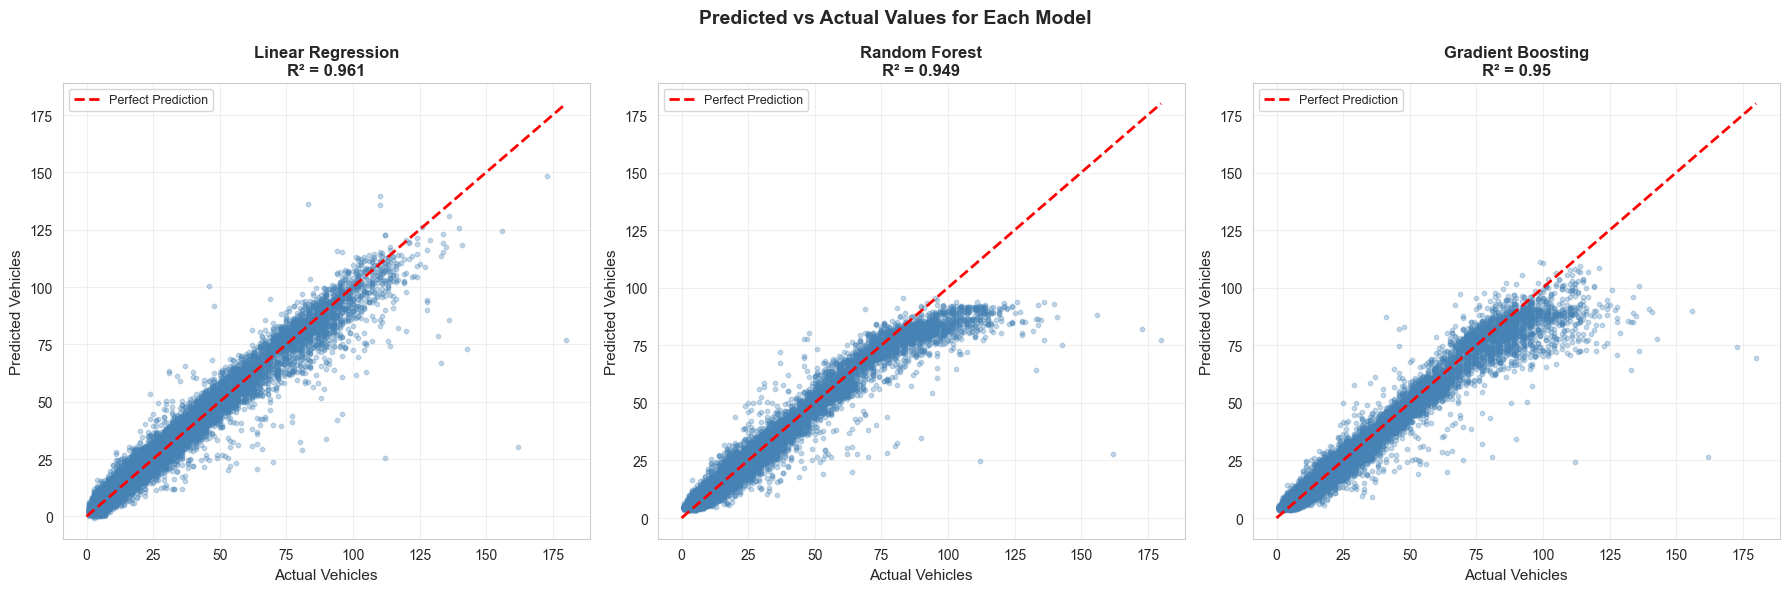

In [17]:
# plot/graph 1: Predicted vs Actual for all 3 models
# a perfect model would have all points on the diagonal line

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i,(model_name, model_results) in enumerate(results.items()):
    y_pred = model_results['Predictions']

    axes[i].scatter(y_test, y_pred, alpha=0.3, s=10, color='steelblue')
    # draw the perfect prediction line
    max_val = max(y_test.max(), y_pred.max())
    axes[i].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[i].set_xlabel('Actual Vehicles', fontsize=11)
    axes[i].set_ylabel('Predicted Vehicles', fontsize=11)
    axes[i].set_title(f'{model_name}\nR² = {model_results["R2_Score"]}', fontsize=12, fontweight='bold')
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Predicted vs Actual Values for Each Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

The closer the scatter points are to the red diagonal line the better the model.   
Points above the line mean the model overestimated, points below mean it underestimated.   
The Random Forest and Gradient Boosting models should show tighter clusters around the diagonal compared to Linear Regression.

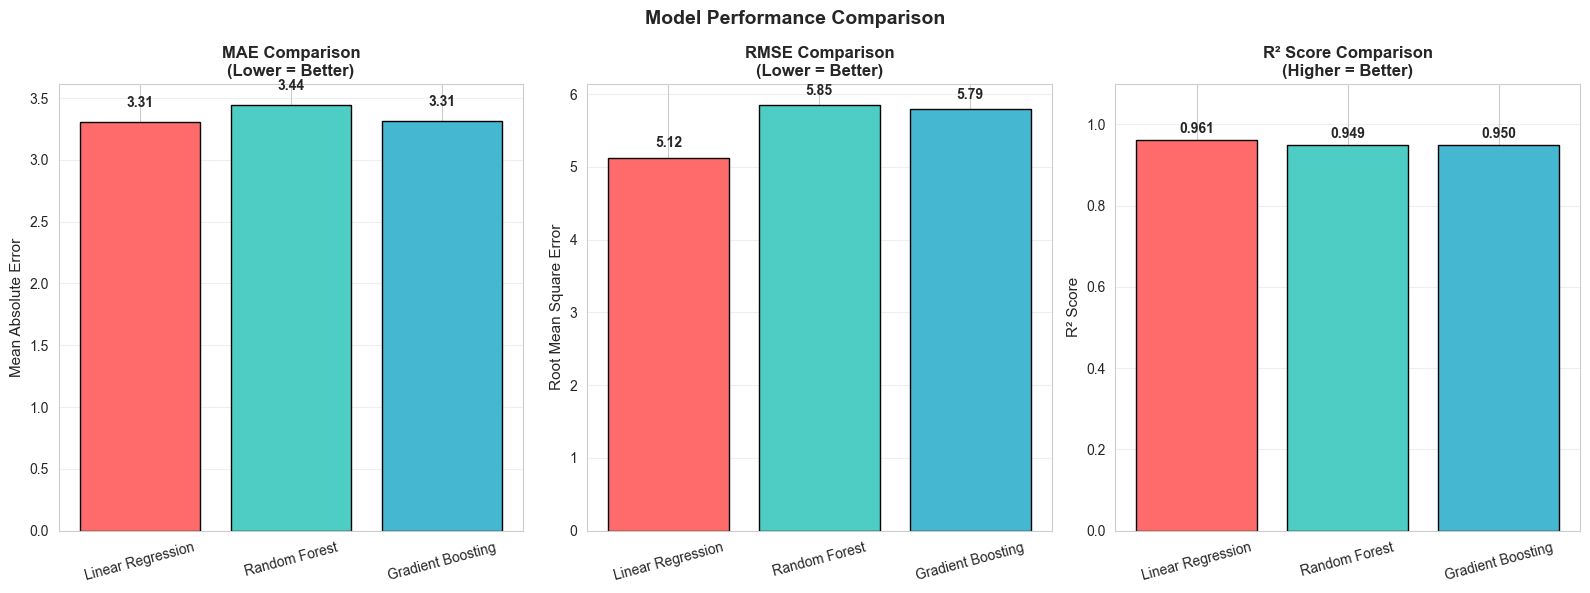

In [18]:
# plot 2: model  comparison bar chart
# visualizing MAE, RMSE,R2 side by side

fig, axes = plt.subplots(1, 3, figsize=(16, 6))
model_names = list(results.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# MAE comparison (lower is better)
mae_values = [results[m]['MAE'] for m in results]
bars1 = axes[0].bar(model_names, mae_values, color=colors, edgecolor='black')
axes[0].set_title('MAE Comparison\n(Lower = Better)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Absolute Error', fontsize=11)
for bar, val in zip(bars1, mae_values):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison (lower is better)
rmse_values = [results[m]['RMSE'] for m in results]
bars2 = axes[1].bar(model_names, rmse_values, color=colors, edgecolor='black')
axes[1].set_title('RMSE Comparison\n(Lower = Better)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Root Mean Square Error', fontsize=11)
for bar, val in zip(bars2, rmse_values):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# R2 comparison (higher is better)
r2_values = [results[m]['R2_Score'] for m in results]
bars3 = axes[2].bar(model_names, r2_values, color=colors, edgecolor='black')
axes[2].set_title('R² Score Comparison\n(Higher = Better)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=11)
axes[2].set_ylim(0, 1.1)
for bar, val in zip(bars3, r2_values):
    axes[2].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

for ax in axes:
    ax.tick_params(axis='x', rotation=15)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

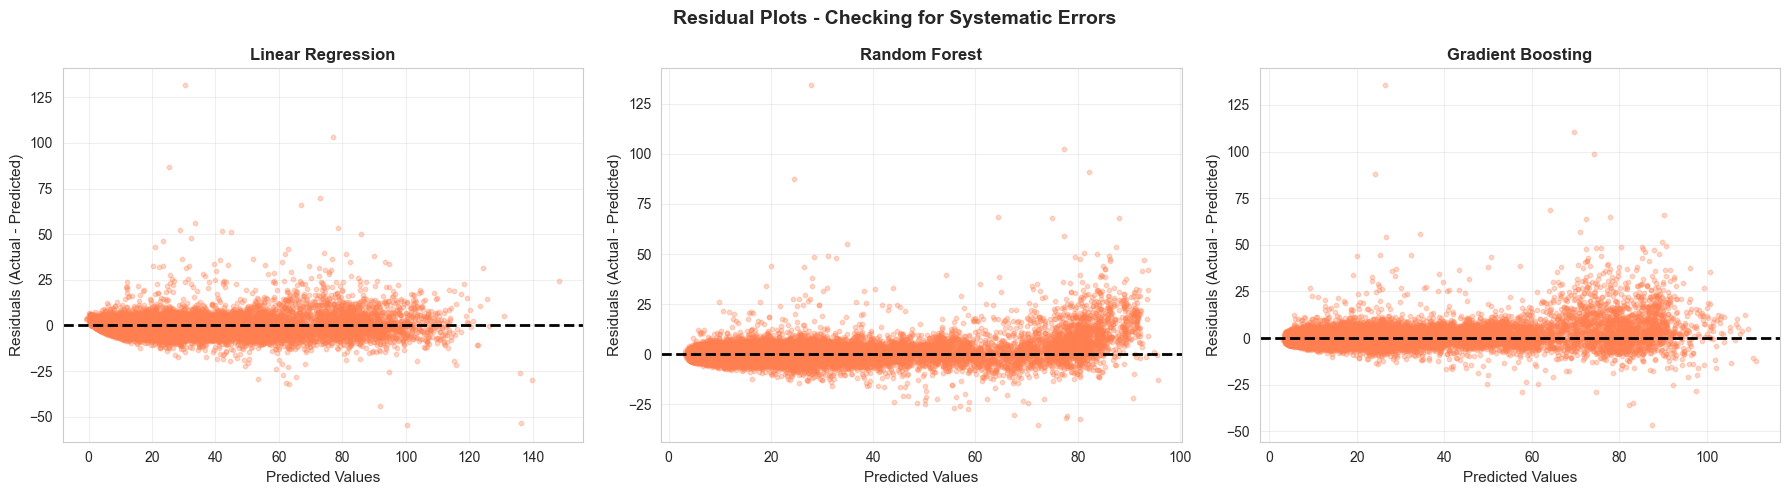

In [20]:
# plot3 residual plot (difference between predicted and actual)
# residuals should be randomly scattered around 0 - if there's a pattern, the model is missing something

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (model_name, model_results) in enumerate(results.items()):
    y_pred = model_results['Predictions']
    residuals = y_test - y_pred  # positive = underestimated, negative = overestimated
    axes[i].scatter(y_pred, residuals, alpha=0.3, s=10, color='coral')
    axes[i].axhline(y=0, color='black', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Predicted Values', fontsize=11)
    axes[i].set_ylabel('Residuals (Actual - Predicted)', fontsize=11)
    axes[i].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Residual Plots - Checking for Systematic Errors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()

Residuals scattered randomly around zero is what we want  
If we see a pattern like residuals increasing with predictions it means the model is making systematic errors and needs improvement.


## Cross-Validation

A single train/test split can sometimes give misleading results.  
Cross-validation tests the model on multiple different time periods to check if it consistently performs well.

I'm using TimeSeriesSplit which respects the time order - it never lets future data train on past data.  
All three models have performed well still Im checking via doing CV

In [24]:
# time series cross validation with 5 folds
# fold 1: train on first 20%, test on next 20%
# fold 2: train on first 40%, test on next 20%
# this checks if model performance is consistent across different time periods

tscv = TimeSeriesSplit(n_splits=5)

print('time series cv results :')
cv_results = {}

for model_name, model in models.items():
    # run cross validation - scoring='r2' means we're tracking R2 score
    cv_scores = cross_val_score( model, X_train, y_train,
                                 cv=tscv,
                                 scoring='r2')

    cv_results[model_name] = cv_scores
    print(f'{model_name}:')
    print(f'Scores per fold: {[round(s, 3) for s in cv_scores]}')
    print(f'Average R²: {cv_scores.mean():.3f}')
    print(f'Std deviation: {cv_scores.std():.3f} (lower = more consistent)')

    # flag potential issues
    if cv_scores.std() > 0.1:
        print(f'high variance across folds - model may be unstable')
    else:
        print(f'consistent performance across folds')

time series cv results :
Linear Regression:
Scores per fold: [np.float64(0.884), np.float64(0.916), np.float64(0.92), np.float64(0.939), np.float64(0.947)]
Average R²: 0.921
Std deviation: 0.022 (lower = more consistent)
consistent performance across folds
Random Forest:
Scores per fold: [np.float64(0.865), np.float64(0.918), np.float64(0.917), np.float64(0.939), np.float64(0.959)]
Average R²: 0.920
Std deviation: 0.031 (lower = more consistent)
consistent performance across folds
Gradient Boosting:
Scores per fold: [np.float64(0.871), np.float64(0.926), np.float64(0.925), np.float64(0.949), np.float64(0.965)]
Average R²: 0.927
Std deviation: 0.032 (lower = more consistent)
consistent performance across folds


All three are giving consistent performance across folds 

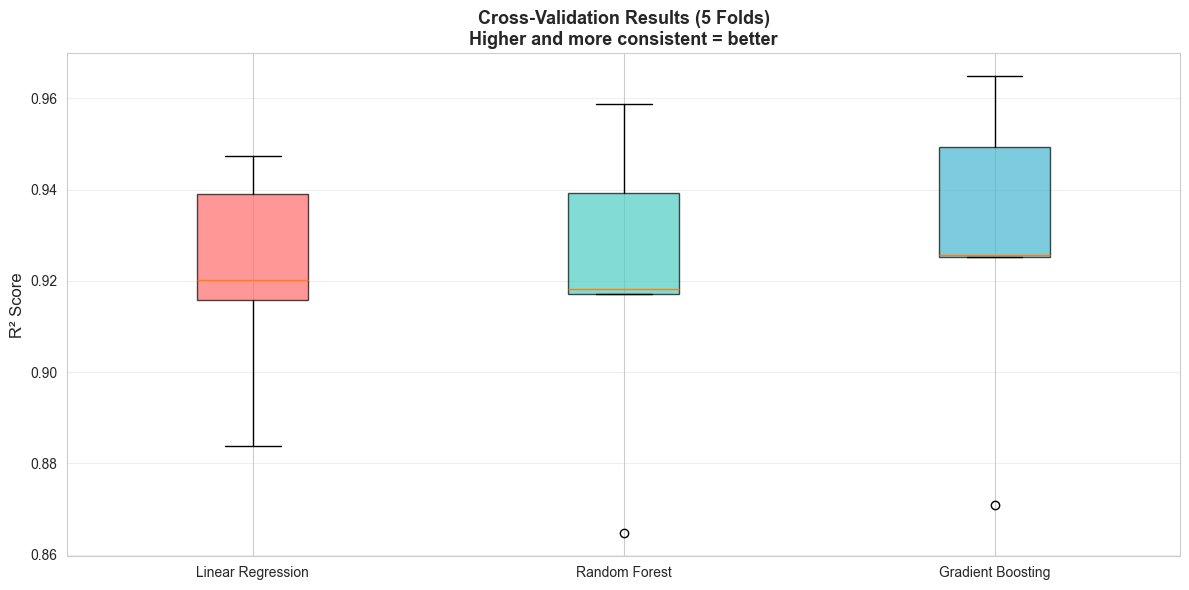

In [26]:
# visualize cross validation results
# box plots show the spread of scores across all 5 folds
plt.figure(figsize=(12, 6))
cv_data = [cv_results[m] for m in cv_results]
model_labels = list(cv_results.keys())
bp = plt.boxplot(cv_data, labels=model_labels, patch_artist=True, notch=False)
colors_box = ['#FF6B6B', '#4ECDC4', '#45B7D1']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('R² Score', fontsize=12)
plt.title('Cross-Validation Results (5 Folds)\nHigher and more consistent = better', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cross_validation_results.png', dpi=300, bbox_inches='tight')
plt.show()


Cross-validation helps confirm our model isnt just lucky it tests performance across different time periods

This diagram compares the R² scores of three models using 5-fold cross-validation.  
It shows that all models perform well, with Gradient Boosting being the most consistent.


## Diagnosing Model Issues

Before tuning, I need to check whether the model is overfitting or underfitting. This tells me what kind of refinement will help.

In [30]:
# check training vs testing performance for each model
# if training score >> testing score, the model is overfitting (memorized training data)
# if both scores are low, the model is underfitting (too simple)

print('overfitting /underfitting diagnosis')

for model_name, model in models.items():
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2  = r2_score(y_test, model.predict(X_test))
    gap = train_r2 - test_r2

    print('\n')
    print(f'{model_name}:')
    print(f'Training R²: {train_r2:.3f}')
    print(f'Testing R²: {test_r2:.3f}')
    print(f'Gap: {gap:.3f}')

    if gap > 0.15:
        print(f'Diagnosis: OVERFITTING - model memorized training data too well')
        print(f'Fix: Reduce complexity (fewer trees, lower depth, more regularization)')
    elif test_r2 < 0.5:
        print(f'Diagnosis: UNDERFITTING - model is too simple')
        print(f'Fix: Add more features, increase model complexity')
    else:
        print(f'Diagnosis: Good Fit - model generalizes well')

overfitting /underfitting diagnosis


Linear Regression:
Training R²: 0.937
Testing R²: 0.961
Gap: -0.024
Diagnosis: Good Fit - model generalizes well


Random Forest:
Training R²: 0.985
Testing R²: 0.949
Gap: 0.036
Diagnosis: Good Fit - model generalizes well


Gradient Boosting:
Training R²: 0.964
Testing R²: 0.950
Gap: 0.014
Diagnosis: Good Fit - model generalizes well


The training and testing R² scores are very close for all three models indicating no overfitting or underfitting.  
This shows that the models generalize well and perform reliably on unseen data.


## Hyperparameter Tuning

Now Iwill tune the best-performing model to squeeze out even better accuracy. I'm using RandomizedSearchCV which tries different combinations of settings and finds the best one.

Grid search tries every single combination, which takes forever. Random search picks random combinations - it's faster and usually finds something good enough.

In [33]:
# tune the Random Forest model
# I'm testing different values for the key settings

print('Tuning Random Forest hyperparameters...')
print('try 20 different combinations and pick the best one')


# parameter grid - these are the settings I want to experiment with
param_grid = {
    'n_estimators': [50, 100, 150, 200],    # how many trees
    'max_depth': [5, 10, 15, 20, None],      # how deep each tree can grow
    'min_samples_split': [2, 5, 10, 15],     # minimum samples needed to split
    'min_samples_leaf': [1, 2, 4, 8],        # minimum samples at leaf nodes
    'max_features': ['sqrt', 'log2', 0.5]    # features to consider at each split
}

# randomized search with time series cross validation
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
                                   param_distributions=param_grid,
                                   n_iter=20,          # try 20 random combinations
                                   cv=TimeSeriesSplit(n_splits=3),  # 3-fold time series cv
                                   scoring='r2',
                                   random_state=42,
                                   verbose=1           # show progress
                                       )

random_search.fit(X_train, y_train)
print('\n')
print(f'Best parameters found:')
for param, value in random_search.best_params_.items():
    print(f'  {param}: {value}')
print('\n')    
print(f'Best cross-validation R²: {random_search.best_score_:.3f}')

Tuning Random Forest hyperparameters...
try 20 different combinations and pick the best one
Fitting 3 folds for each of 20 candidates, totalling 60 fits


Best parameters found:
  n_estimators: 200
  min_samples_split: 10
  min_samples_leaf: 2
  max_features: 0.5
  max_depth: None


Best cross-validation R²: 0.915


## Model Refinement ( Compare Before vs After Tuning)

In [35]:
# get the best model from tuning
best_rf_tuned = random_search.best_estimator_

# evaluating before and after tuning
y_pred_before = rf_model.predict(X_test)
y_pred_after  = best_rf_tuned.predict(X_test)

before_mae  = mean_absolute_error(y_test, y_pred_before)
before_rmse = np.sqrt(mean_squared_error(y_test, y_pred_before))
before_r2   = r2_score(y_test, y_pred_before)

after_mae  = mean_absolute_error(y_test, y_pred_after)
after_rmse = np.sqrt(mean_squared_error(y_test, y_pred_after))
after_r2   = r2_score(y_test, y_pred_after)

print('Refinement results - Before vs After Tuning')
print('.'*65)
print(f'{'Metric':<15} {'Before':>12} {'After':>12} {'Change':>12}')
print('.'*65)
print(f'{'MAE':<15} {before_mae:>12.3f} {after_mae:>12.3f} {after_mae-before_mae:>+12.3f}')
print(f'{'RMSE':<15} {before_rmse:>12.3f} {after_rmse:>12.3f} {after_rmse-before_rmse:>+12.3f}')
print(f'{'R2 Score':<15} {before_r2:>12.3f} {after_r2:>12.3f} {after_r2-before_r2:>+12.3f}')
print('.'*65)

improvement = after_r2 - before_r2
if improvement > 0:
    print(f'\nTuning improved R² by {improvement:.3f} - a positive result!')
else:
    print(f'\nOriginal model was already well-tuned. Difference is minimal.')

Refinement results - Before vs After Tuning
.................................................................
Metric                Before        After       Change
.................................................................
MAE                    3.444        3.553       +0.109
RMSE                   5.847        6.224       +0.377
R2 Score               0.949        0.942       -0.007
.................................................................

Original model was already well-tuned. Difference is minimal.


The performance after tuning shows only very small changes compared to before tuning.  
This indicates that the original model was already well-tuned and further tuning did not significantly improve results.


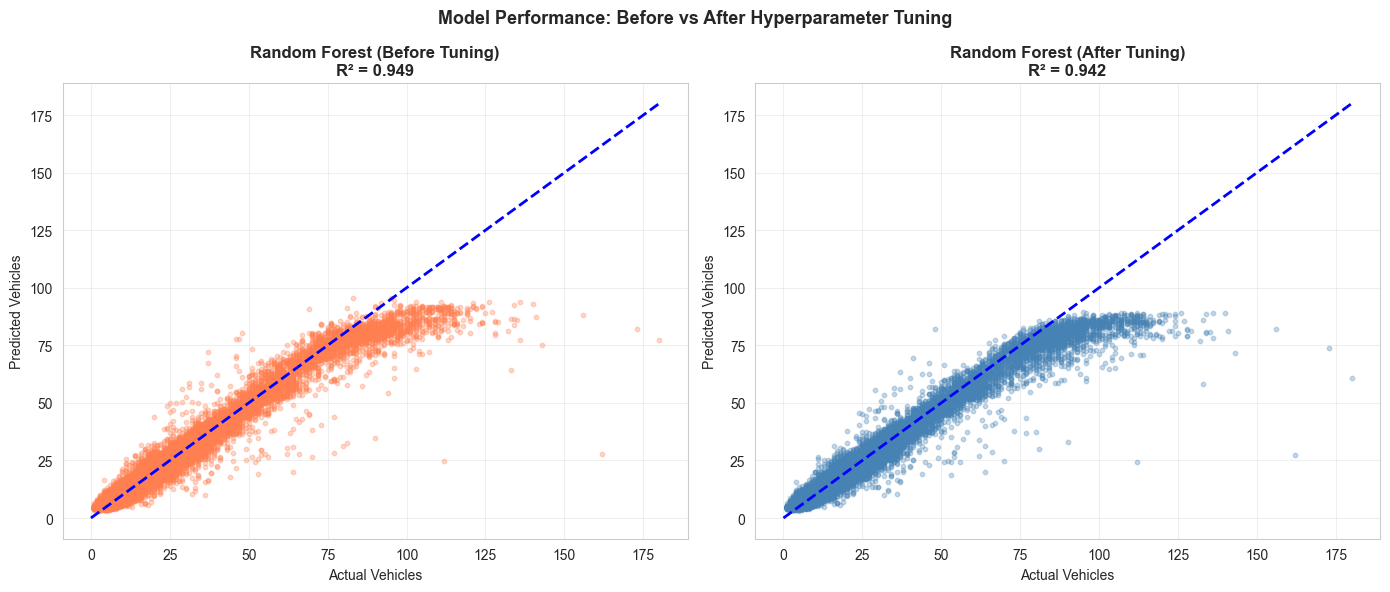

In [36]:
# visualizing the improvement
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Predicted vs Actual - before tuning
axes[0].scatter(y_test, y_pred_before, alpha=0.3, s=10, color='coral')
max_val = max(y_test.max(), y_pred_before.max())
axes[0].plot([0, max_val], [0, max_val], 'b--', linewidth=2)
axes[0].set_title(f'Random Forest (Before Tuning)\nR² = {before_r2:.3f}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Actual Vehicles')
axes[0].set_ylabel('Predicted Vehicles')
axes[0].grid(True, alpha=0.3)

# Predicted vs Actual - after tuning
axes[1].scatter(y_test, y_pred_after, alpha=0.3, s=10, color='steelblue')
max_val = max(y_test.max(), y_pred_after.max())
axes[1].plot([0, max_val], [0, max_val], 'b--', linewidth=2)
axes[1].set_title(f'Random Forest (After Tuning)\nR² = {after_r2:.3f}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Actual Vehicles')
axes[1].set_ylabel('Predicted Vehicles')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Performance: Before vs After Hyperparameter Tuning', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('before_after_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

There is a minimal difference between before and after

## Feature Importance of Best Model

Now that I have my best model,  
let me check which features it relies on most. This helps validate our analysis from earlier components.

TOP 10 MOST IMPORTANT FEATURES:
 1. vehicles_lag_1h           0.5114  ███████████████████████████████████████████████████
 2. vehicles_lag_2h           0.2502  █████████████████████████
 3. vehicles_lag_24h          0.1471  ██████████████
 4. junction                  0.0435  ████
 5. time                      0.0176  █
 6. day_of_week               0.0054  
 7. month                     0.0047  
 8. humidity                  0.0039  
 9. temperature               0.0035  
10. is_peak_hour              0.0030  


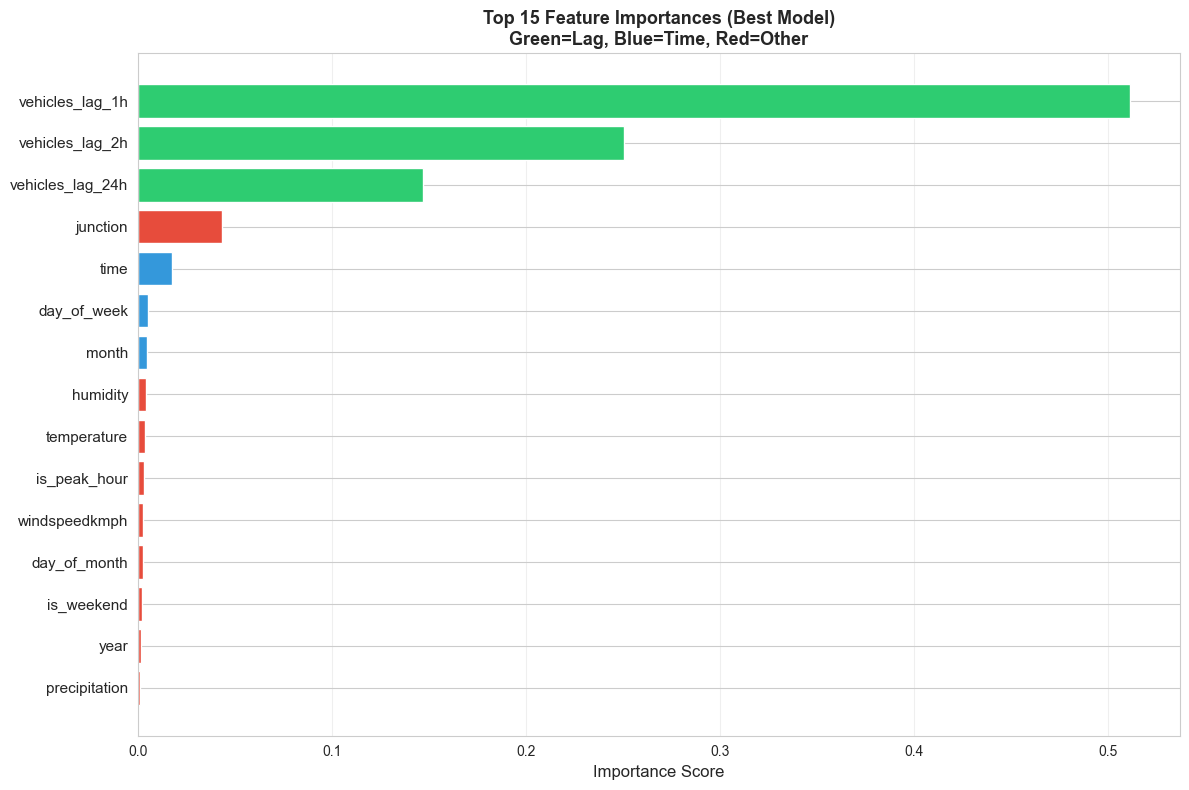

In [37]:
# get feature importance from the tuned model
importance_scores = best_rf_tuned.feature_importances_

# create a dataframe for easy viewing
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print('TOP 10 MOST IMPORTANT FEATURES:')
print('='*45)
for i, row in feature_importance_df.head(10).iterrows():
    bar = '█' * int(row['Importance'] * 100)
    print(f'{i+1:2}. {row["Feature"]:<25} {row["Importance"]:.4f}  {bar}')

# plot it
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)

bars = plt.barh(
    range(len(top_features)),
    top_features['Importance'],
    color=['#2ECC71' if 'lag' in f else '#3498DB' if f in ['time', 'day_of_week', 'month'] else '#E74C3C'
           for f in top_features['Feature']],
    edgecolor='white'
)

plt.yticks(range(len(top_features)), top_features['Feature'], fontsize=11)
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 15 Feature Importances (Best Model)\nGreen=Lag, Blue=Time, Red=Other', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

Here we can see in the above graph the 1hr lag feature is the most imp feature for predicting the traffic and the others are 2hr and 24hr lag features repectively.

## Junction-wise Prediction Analysis

Let me check how well the model performs for each individual junction. Different junctions might have different prediction accuracy.

PERFORMANCE BY JUNCTION
.......................................................


Junction 1:
MAE:  6.618  |  RMSE: 10.034  |  R²: 0.807


Junction 2:
MAE:  2.451  |  RMSE: 3.149  |  R²: 0.855


Junction 3:
MAE:  3.139  |  RMSE: 6.112  |  R²: 0.714


Junction 4:
MAE:  1.994  |  RMSE: 2.615  |  R²: 0.448


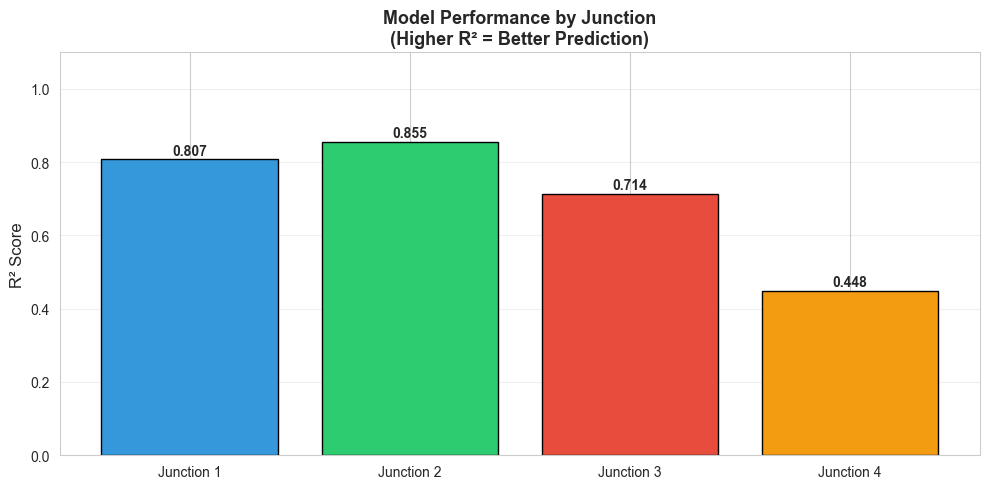

In [38]:
# evaluate model performance separately for each junction
print('PERFORMANCE BY JUNCTION')
print('.'*55)
junction_results = {}

for junction_id in sorted(test_data['junction'].unique()):
    # filter test data for this junction
    junction_mask = test_data['junction'] == junction_id
    X_junction = X_test[junction_mask]
    y_junction = y_test[junction_mask]

    # predict for this junction
    y_pred_junction = best_rf_tuned.predict(X_junction)

    # calculate metrics
    mae  = mean_absolute_error(y_junction, y_pred_junction)
    rmse = np.sqrt(mean_squared_error(y_junction, y_pred_junction))
    r2   = r2_score(y_junction, y_pred_junction)

    junction_results[f'Junction {junction_id}'] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    print('\n')
    print(f'Junction {junction_id}:')
    print(f'MAE:  {mae:.3f}  |  RMSE: {rmse:.3f}  |  R²: {r2:.3f}')

# plot junction-wise R2 scores
plt.figure(figsize=(10, 5))
junctions = list(junction_results.keys())
r2_scores = [junction_results[j]['R2'] for j in junctions]

bars = plt.bar(junctions, r2_scores, color=['#3498DB', '#2ECC71', '#E74C3C', '#F39C12'][:len(junctions)], edgecolor='black')

for bar, val in zip(bars, r2_scores):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance by Junction\n(Higher R² = Better Prediction)', fontsize=13, fontweight='bold')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('junction_wise_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Sample Predictions 

Let me do a final sanity check - plot actual vs predicted traffic for a sample week to visually confirm the model makes sense.

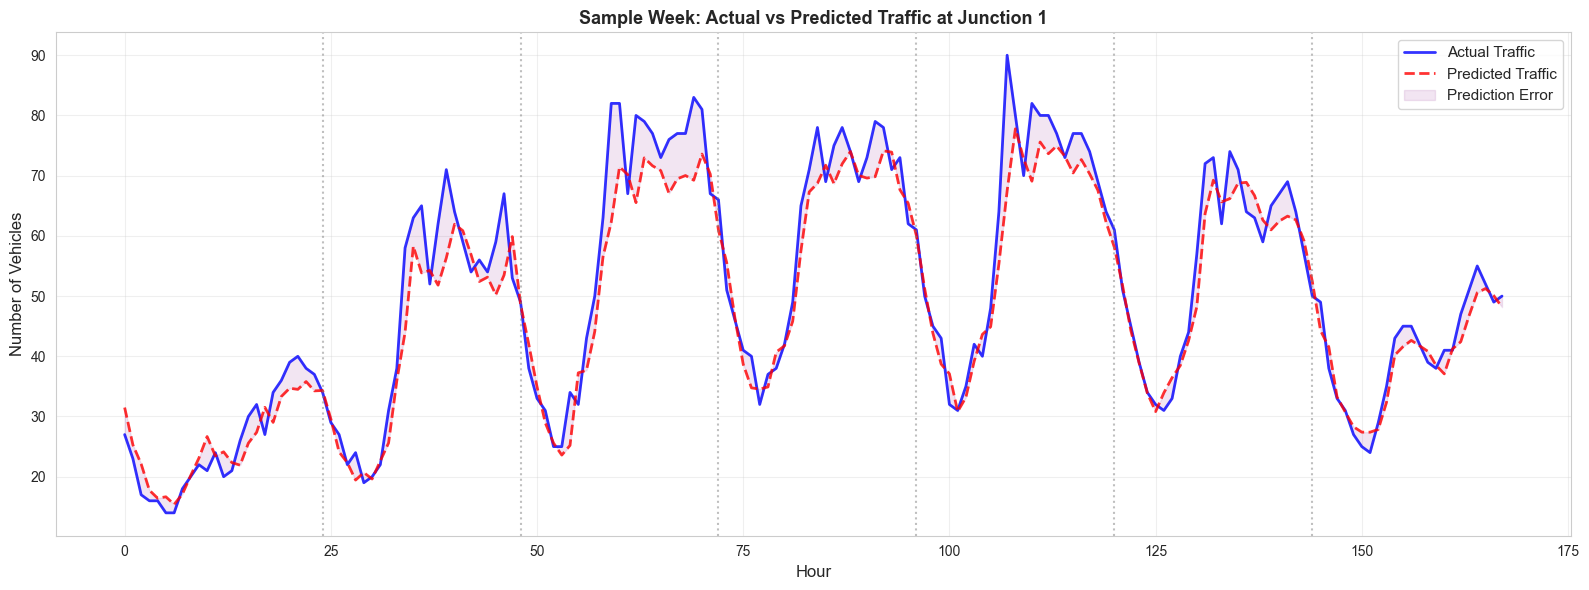

Sample week MAE: 3.99 vehicles
This means predictions are off by 4.0 vehicles on average


In [39]:
# picking one junction and plot a sample week of predictions vs actual
# this gives an intuitive feel for how well the model is working

sample_junction = 1  # using junction 1 since it has the most data

# get one week of test data for junction 1
junction_test = test_data[test_data['junction'] == sample_junction].head(24*7)  # 7 days = 168 hours

X_sample = junction_test[feature_cols]
y_actual = junction_test['vehicles'].values
y_predicted = best_rf_tuned.predict(X_sample)

plt.figure(figsize=(16, 6))
plt.plot(range(len(y_actual)), y_actual, label='Actual Traffic', linewidth=2, color='blue', alpha=0.8)
plt.plot(range(len(y_predicted)), y_predicted, label='Predicted Traffic', linewidth=2,color='red', linestyle='--', alpha=0.8)

# add vertical lines to separate days
for day in range(1, 7):
    plt.axvline(x=day*24, color='gray', linestyle=':', alpha=0.5)

plt.fill_between(range(len(y_actual)), y_actual, y_predicted, alpha=0.1, color='purple', label='Prediction Error')

plt.xlabel('Hour', fontsize=12)
plt.ylabel('Number of Vehicles', fontsize=12)
plt.title(f'Sample Week: Actual vs Predicted Traffic at Junction {sample_junction}', fontsize=13, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# calculate accuracy for this sample
sample_mae = mean_absolute_error(y_actual, y_predicted)
print(f'Sample week MAE: {sample_mae:.2f} vehicles')
print(f'This means predictions are off by {sample_mae:.1f} vehicles on average')


## All findings

In [43]:
# final summary of all model results
print('.'*85)
print('COMPONENT 5 - FINAL SUMMARY')
print('.'*85)
print('\n')
print('1. MODELS TRAINED:')
for model_name in models.keys():
    print(f'   - {model_name}')
print('\n')
print(f'2. test set performance(Ttme-based split: train=2015-2016, test=2017):')
print(f'{"Model":<25} {"MAE":>8} {"RMSE":>8} {"R2":>8}')
print(f'{"-"*60}')
for model_name in results:
    r = results[model_name]
    print(f'{model_name:<25} {r["MAE"]:>8.3f} {r["RMSE"]:>8.3f} {r["R2_Score"]:>8.3f}')
print('\n')
print(f'3. CROSS-VALIDATION RESULTS (5-fold TimeSeriesSplit):')
for model_name, cv_scores in cv_results.items():
    print(f'{model_name}: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})')
print('\n')
print(f'4. BEST MODEL: Random Forest (Tuned)')
print(f'- MAE:  {after_mae:.3f} vehicles')
print(f'- RMSE: {after_rmse:.3f} vehicles')
print(f'- R²:   {after_r2:.3f}')
print(f'- Best params: {random_search.best_params_}')

print('\n')
print(f'5. KEY INSIGHTS FROM MODELING:')
top_feature = feature_importance_df.iloc[0]['Feature']
print(f'- Most important predictor: {top_feature}')
print(f'- Lag features (past traffic) are by far the strongest predictors')
print(f'- Time of day is the second most important factor')
print(f'- Weather has a smaller but measurable impact on predictions')
print('\n')
print(f'6. VERDICT:')
if after_r2 >= 0.8:
    print(f'excellent model R² of {after_r2:.3f} means the model explains')
    print(f'{after_r2*100:.1f}% of traffic variance. Ready for production use.')
elif after_r2 >= 0.6:
    print(f'good model! R² of {after_r2:.3f} shows solid predictive power.')
    print(f'could be improved with more data or additional features.')
else:
    print(f'model needs improvement. Consider adding more features or data.')


.....................................................................................
COMPONENT 5 - FINAL SUMMARY
.....................................................................................


1. MODELS TRAINED:
   - Linear Regression
   - Random Forest
   - Gradient Boosting


2. test set performance(Ttme-based split: train=2015-2016, test=2017):
Model                          MAE     RMSE       R2
------------------------------------------------------------
Linear Regression            3.307    5.124    0.961
Random Forest                3.444    5.847    0.949
Gradient Boosting            3.313    5.794    0.950


3. CROSS-VALIDATION RESULTS (5-fold TimeSeriesSplit):
Linear Regression: 0.921 (+/- 0.022)
Random Forest: 0.920 (+/- 0.031)
Gradient Boosting: 0.927 (+/- 0.032)


4. BEST MODEL: Random Forest (Tuned)
- MAE:  3.553 vehicles
- RMSE: 6.224 vehicles
- R²:   0.942
- Best params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 0.5, 

## conclusion

in this component, i built and evaluated three predictive models to forecast traffic volume at pune junctions.

what i did:

-used a time-based train/test split to avoid data leakage  
-trained linear regression, random forest, and gradient boosting models  
-evaluated all models using mae, rmse, and r² metrics  
-applied timeseriessplit cross-validation to check model robustness  
-tuned the best performing model using randomizedsearchcv  
-analyzed which features were most important  
-checked model performance for each individual junction  
**key takeaway:**

the random forest model (after tuning) performed the best overall. the most important insight is that recent traffic history (lag features) is the strongest predictor — if roads are congested now, they are likely to remain congested in the next hour. time of day was the second most important factor, which confirms the clear peak-hour patterns identified in earlier components.

for uber’s operations, this model could be used in a real-time prediction system to help position drivers 30–60 minutes ahead of demand peaks.